In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy

#Import some image analysis functions
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

import sys

##################################################################################################
# CHANGE THIS TO THE PATH WHERE THE DDM CODE IS (GET FROM GITHUB IF YOU HAVEN'T YET)             #
path_to_ddm_code = "C:\\Users\\rmcgorty\\Documents\\GitHub\\Differential-Dynamic-Microscopy---Python\\"
##################################################################################################

sys.path.append(path_to_ddm_code)

import tiff_file
import ddm_clean as ddm

C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
%matplotlib notebook

Imports not working? Make sure to grab the [DDM repository from GitHub](https://github.com/rmcgorty/Differential-Dynamic-Microscopy---Python). 

Don't know what all those scipy.ndimage functions are? [Check out the documentation](https://docs.scipy.org/doc/scipy/reference/ndimage.html). 

In [3]:
def im_corr(image, filter=False, filtersize=80):
    '''
    This function computes the image correlation. 
    Inputs:
        image - the 2D matrix of the image
        filter (optional) - boolean, defaults to False. Whether or not to filter image using the uniform filter
        filtersize (optional) - defaults to 80. Size of filter
    Outputs:
        corr_im - the correlation (same size as input image)
        rav_corr - radially averaged correlation
    '''
    
    #If the 'filter' optional argument is true, then filter the image
    if filter:
        image = filtimage(image, filtersize = filtersize)
        
    #Subtract of the mean and divide by standard deviation (so that the maximum
    #  of the correlation function will be 1)
    image = 1.0*image-image.mean()
    image = image/image.std()
    
    #Use Fourier transforms to calculate the correlation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #Compute radial average
    rav_corr = ddm.newRadav(corr_im)
    
    
    return corr_im, rav_corr

def filtimage(image, filtersize=80):
    '''
    Filters image using the scipy.ndimage function uniform_filter
    '''
    image = image*1.0 - uf(image,filtersize)
    return image

In [3]:
#Set directory where to find the data:
data_dir = ".\\" 

#Set the data filename
data_file = "Temp Ramp_5Hz_(23-34Deg)20x_1_MMStack_Default.ome_Frame50.tif"

In [4]:
im = tiff_file.imread(data_dir+data_file)
if im.ndim == 2:
    print("Shape of ims is %i,%i" % im.shape)
elif im.ndim == 3:
    print("You'll need to get just one slice (needs a 2D image).")

Shape of ims is 492,656


<IPython.core.display.Javascript object>


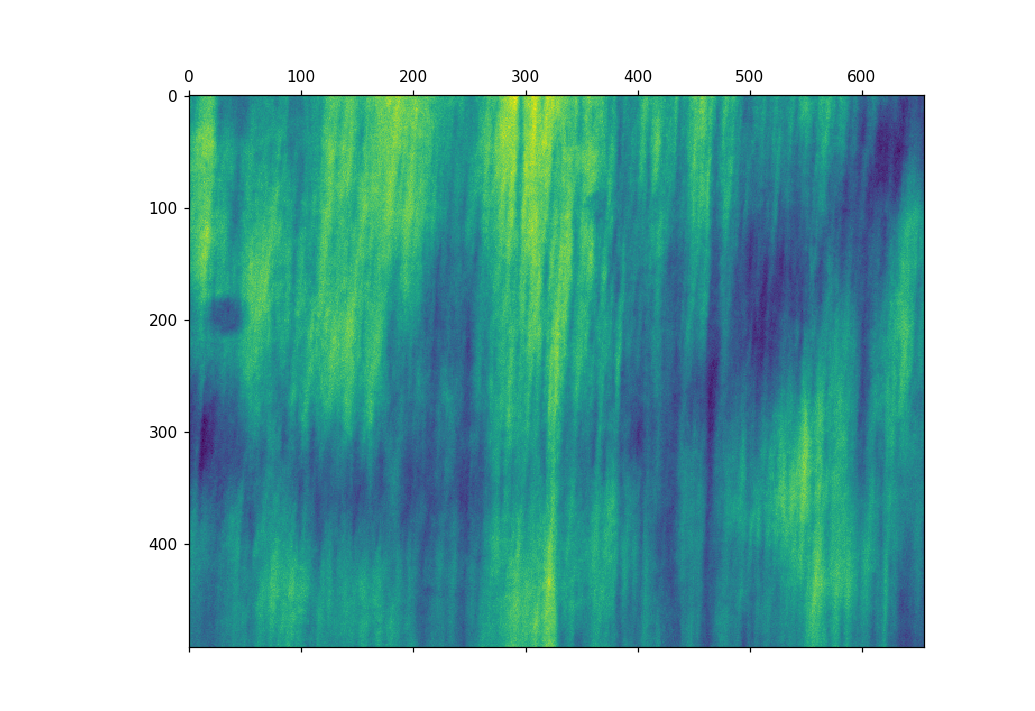

In [7]:
plt.matshow(im)

<IPython.core.display.Javascript object>


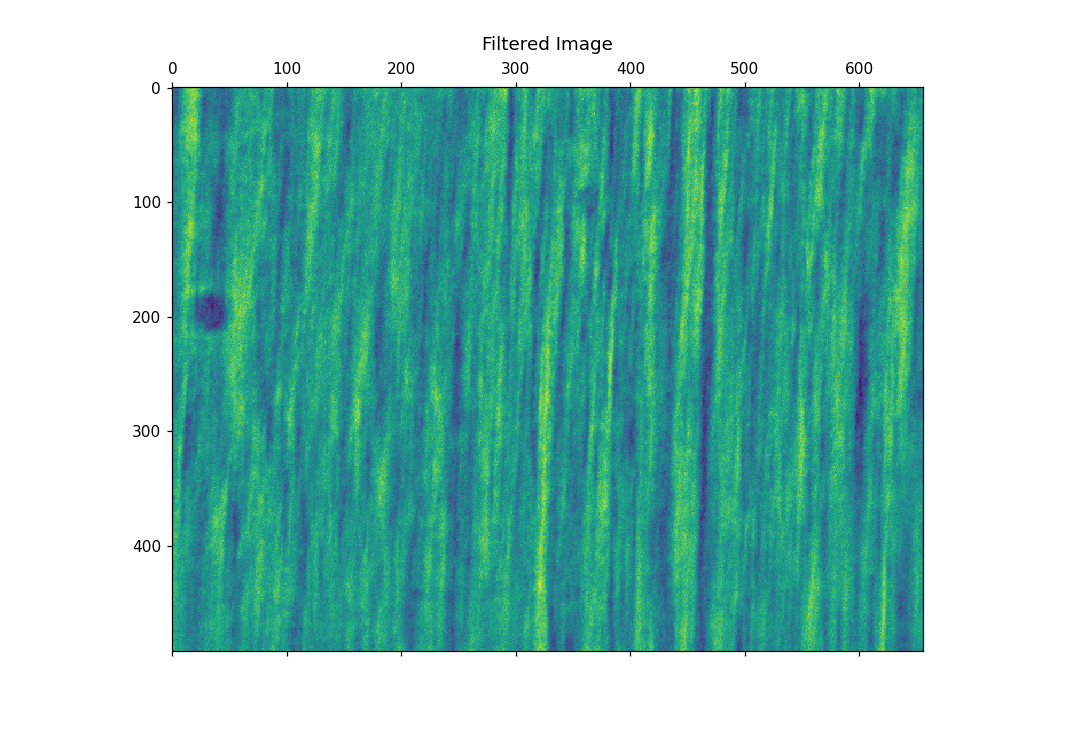

Text(0.5, 1.05, 'Filtered Image')

In [8]:
im_filt = filtimage(im, filtersize=50)
plt.figure()
plt.matshow(im_filt, fignum=0)
plt.title("Filtered Image")

In [9]:
corr_im, corr_rad = im_corr(im,filter=True,filtersize=50)

<IPython.core.display.Javascript object>


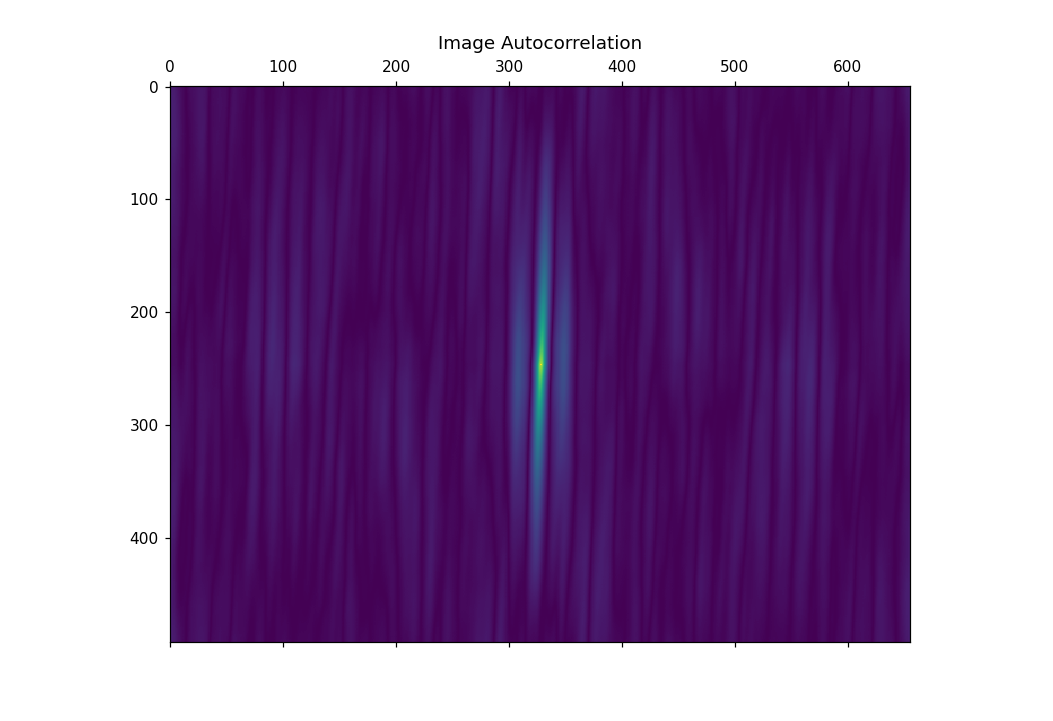

Text(0.5, 1.05, 'Image Autocorrelation')

In [10]:
plt.figure()
plt.matshow(corr_im, fignum=0)
plt.title("Image Autocorrelation")

Look at the image correlation. Does it make sense to take the radially average?

[Text(0, 0, '1.0'), Text(0, 0, '10'), Text(0, 0, '40')]

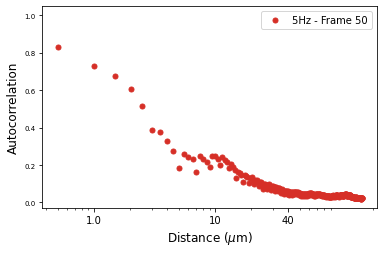

In [28]:
#Here, we plot the radially average.
#Note that it may make no sense to take the radial average if we don't have radial symmetry

cmap = matplotlib.cm.get_cmap('RdYlBu')

figsize = 6.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(len(corr_rad))*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, corr_rad,'.',ms=markerSize,c=cmap(0.1),label="5Hz - Frame 50")
plt.xlabel("Distance ($\mu$m)",fontsize=12)
plt.ylabel("Autocorrelation",fontsize=12)
plt.legend(loc=0,fontsize=10)


ax.set_xticks([1.0, 10, 40])
ax.set_xticklabels(['1.0','10','40'], fontsize=10)


<IPython.core.display.Javascript object>


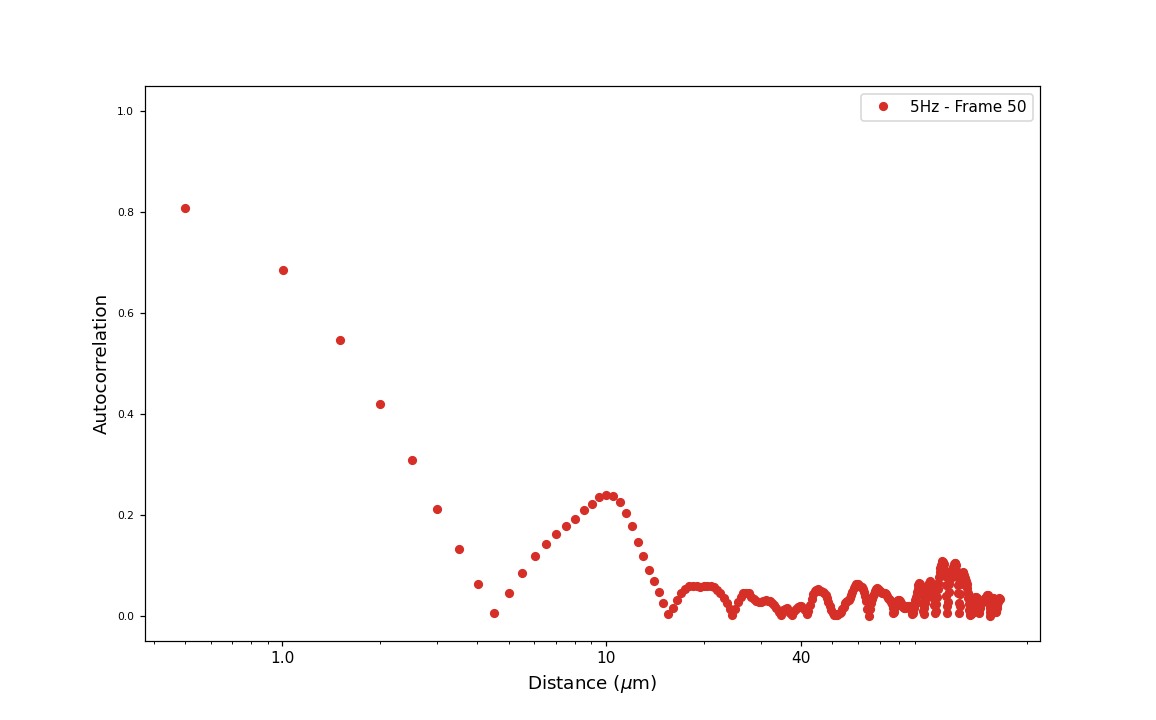

[Text(0, 0, '1.0'), Text(0, 0, '10'), Text(0, 0, '40')]

In [11]:
#Here, we plot a *horizontal* slice through the image autocorrelation.
#Note that it may make no sense to take the radial average if we don't have radial symmetry

cmap = matplotlib.cm.get_cmap('RdYlBu')

nx,ny = corr_im.shape
x_mid = int(nx/2); y_mid = int(ny/2)

figsize = 6.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(y_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, np.flip(corr_im[x_mid, 0:y_mid+1]),'.',ms=markerSize,c=cmap(0.1),label="5Hz - Frame 50")
plt.xlabel("Distance ($\mu$m)",fontsize=12)
plt.ylabel("Autocorrelation",fontsize=12)
plt.legend(loc=0,fontsize=10)


ax.set_xticks([1.0, 10, 40])
ax.set_xticklabels(['1.0','10','40'], fontsize=10)

[Text(0, 0, '1.0'), Text(0, 0, '10'), Text(0, 0, '40')]

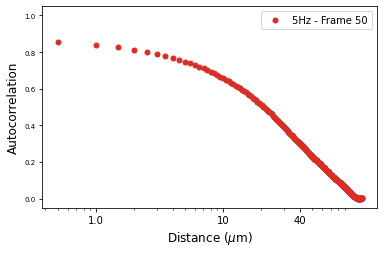

In [45]:
#Here, we plot a *horizontal* slice through the image autocorrelation.
#Note that it may make no sense to take the radial average if we don't have radial symmetry

cmap = matplotlib.cm.get_cmap('RdYlBu')

nx,ny = corr_im.shape
x_mid = int(nx/2); y_mid = int(ny/2)

figsize = 6.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(x_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, np.flip(corr_im[0:x_mid+1, y_mid]),'.',ms=markerSize,c=cmap(0.1),label="5Hz - Frame 50")
plt.xlabel("Distance ($\mu$m)",fontsize=12)
plt.ylabel("Autocorrelation",fontsize=12)
plt.legend(loc=0,fontsize=10)


ax.set_xticks([1.0, 10, 40])
ax.set_xticklabels(['1.0','10','40'], fontsize=10)